In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pubs = pd.read_csv('open_pubs.csv')

pubs['latitude'] = pd.to_numeric(pubs['latitude'], errors = 'coerce')
pubs['longitude'] = pd.to_numeric(pubs['longitude'], errors = 'coerce')

In [3]:
print(f"Size of dataframe before dropping the nan elements: {len(pubs)}")

Size of dataframe before dropping the nan elements: 51498


In [4]:
#Need to remove entries where there is a nan
pubs = pubs.drop(pubs[pubs['longitude'].isna()].index)
pubs = pubs.drop(pubs[pubs['latitude'].isna()].index)
print(f"Size of dataframe before dropping the nan elements: {len(pubs)}")

Size of dataframe before dropping the nan elements: 51498


Spicy facts to be found:
* Furthest point away from any bar
* Bar with the longest name
* Bar with the shortest name
* Oldest bar
* Biggest bar (in term of area)
* Smallest bar
* Most expensive bar
* Favorite Bar of the King (Harry or the other)
* Most famous Bar where the Beatles played
* ...

## Furthest point away from any bar

We do a rough estimation where the furthest point from any bar is.

As this is not trivial we do it like this:
* Create a boundary area inside the land by looking at the longitude and latitude of england on a map
* Sample random points inside the area
* Find point at max distance from any bar
* Create a new zone centered on this point
* Resample points to find exact position

We run this algorithm multiple time to see if we always get the same result

In [5]:
x = pubs['longitude']
y = pubs['latitude']

In [55]:
boundaries = np.array([[50.188037,-5.196287],
[50.966788,-1.590941],
[51.077358,1.003247],
[51.475966,0.299739],
[52.410518,1.618818],
[52.597765,0.202959],
[52.969871,-0.170780],
[53.181076,0.180974],
[54.524934,-0.905976],
[54.628941,-1.371318],
[55.693713,-2.162784],
[55.031826,-2.910262],
[54.058985,-2.690415],
[53.332650,-3.078930],
[52.844392,-3.969309],
[51.626685,-3.716485],
[51.844404,-2.298475],
[51.190390,-2.892061],
[50.188037,-5.196287]                ])

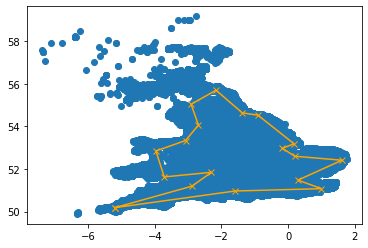

In [56]:
plt.plot(boundaries[:,1], boundaries[:,0], marker = 'x', c = 'orange')
plt.scatter(x, y)

In [57]:
from shapely.geometry import Polygon, Point
import pointpats

In [58]:
bars_location = np.array(list(zip(y,x)))

In [65]:

nb_random_points = 5000
radius = [0.08, 0.001] #decreasing radius size to create second zone where we create points
keep_point = []
nb_runs = 5
for i in range(nb_runs):
    poly = Polygon(boundaries)
    iteration = 0
    while (iteration < 2):
        points = pointpats.random.poisson(poly, size=nb_random_points) #Generates random points within the polygone
        distances = np.zeros(len(points))
        for i,random_point in tqdm(enumerate(points)):
            distances[i] = np.min(np.linalg.norm(random_point -  bars_location, axis = 1))# For each random point, compute the min dist between the point and all bars
        
        #Take the random_point that is the furthest away from all points
        furthest_point = points[np.argmax(distances)] #Finds the max min distance
        iteration +=1
    keep_point.append(furthest_point)

5000it [00:04, 1007.30it/s]
5000it [00:04, 1022.93it/s]
5000it [00:04, 1017.13it/s]
5000it [00:04, 1014.59it/s]
5000it [00:05, 975.65it/s] 
5000it [00:04, 1016.89it/s]
5000it [00:05, 992.13it/s] 
5000it [00:05, 950.36it/s] 
5000it [00:04, 1002.44it/s]
5000it [00:04, 1007.29it/s]


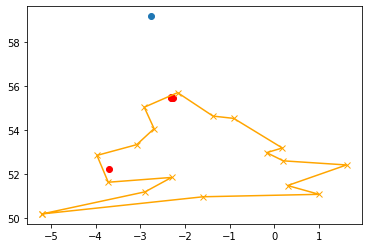

In [73]:
plt.plot(boundaries[:,1], boundaries[:,0], marker = 'x', c = 'orange')#
#plt.scatter(x, y)
keep_point = np.array(keep_point)
plt.scatter(x = keep_point[:,1], y = keep_point[:,0], c='red')
plt.scatter(x = x[47176], y = y[47176])

In [74]:
keep_point

array([[55.45782877, -2.26814956],
       [55.4677785 , -2.31083246],
       [55.49057203, -2.30319293],
       [55.4670397 , -2.28968815],
       [52.24837078, -3.70656611]])

## Bar furthest away from any bar 

In [68]:
bars_location = np.array(list(zip(y,x)))

In [69]:
distances = np.zeros(len(x))
for i in tqdm(range(len(x))):
    point = bars_location[i]
    all_dist = np.linalg.norm(point - bars_location, axis = 1)
    all_dist[i] = np.inf #Need to remove the point itself
    distances[i] = all_dist[np.argmin(all_dist)]    


100%|███████████████████████████████████████████████████████████████████████████| 51498/51498 [00:55<00:00, 931.10it/s]


In [70]:
furthest_pub_away = bars_location[distances.argmax()]

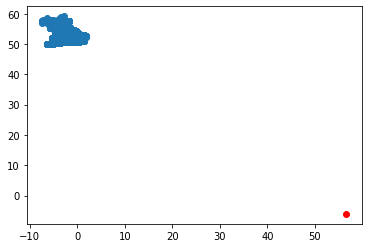

In [71]:
plt.scatter(x, y)
plt.scatter(x = furthest_pub_away[0], y = furthest_pub_away[1], color = 'red')

In [72]:
pubs.iloc[distances.argmax()]

Unnamed: 0                                                     44612
Unnamed: 0.1                                                 44678.0
fas_id                                                      444208.0
name                                                      MacGochans
address            Macgochan's Restaurant Tobermory Isle Of Mull ...
postcode                                                    PA75 6NR
easting                                                     150432.0
northing                                                    755063.0
latitude                                                   56.620741
longitude                                                  -6.069821
local_authority                                      Argyll and Bute
population                                                   86260.0
Name: 44612, dtype: object

## Bar with shortest/longest name

In [11]:
ordered_names = np.argsort(pubs['name'].apply(lambda x: len(x)))
shortest_name_indices = list(ordered_names[0:10])
longest_name_indices = list(ordered_names[::-1][0:10])

In [12]:
for row, content in pubs.iloc[longest_name_indices].iterrows():
    print(f"Name: {content['name']}, length of name: {len(content['name'])}, lat, long = {content['latitude'], content['longitude']}")

Name: Feniscowles and Pleasington Sports And Social Club mail to other addr), length of name: 70, lat, long = (53.72325, -2.534871)
Name: Love Your Greens Catering, King George Fields Indoor Bowls Club, length of name: 63, lat, long = (51.36996, -0.285478)
Name: Holy Trinity Community and Partnership Centre, Community Hall, length of name: 61, lat, long = (53.070715, -0.817595)
Name: Hammersmith Riverside Events @ Auriol Kensington Rowing Club, length of name: 60, lat, long = (51.489855, -0.231434)
Name: Merthyr Vale & Aberfan Social Democratic Club & Institute Lt, length of name: 60, lat, long = (51.695897, -3.344356)
Name: London Midland Railway Clubs Association (Walsall Branch) We, length of name: 60, lat, long = (52.57405, -1.993551)
Name: Derbyshire Catering The Nailers - Belper Meadows Sports Club, length of name: 60, lat, long = (53.026261, -1.48573)
Name: The Milk Bar Arts and Entertainment Appreciation Society CIC, length of name: 60, lat, long = (51.456546, -2.580442)
Name: 

First one with 70 letters seems to have a mistake, so we take the second one

In [15]:
for row, content in pubs.iloc[shortest_name_indices].iterrows():
    print(f"Name: {content['name']}, length of name: {len(content['name'])}, lat, long = {content['latitude'], content['longitude']}")

Name: v, length of name: 1, lat, long = (52.191353, 1.000189)
Name: G6, length of name: 2, lat, long = (51.595438, -3.782497)
Name: O2, length of name: 2, lat, long = (52.621929, -1.123824)
Name: Ox, length of name: 2, lat, long = (50.72351, -1.954668)
Name: C2, length of name: 2, lat, long = (53.237331, -1.424278)
Name: HD, length of name: 2, lat, long = (53.473981, -2.243351)
Name: 85, length of name: 2, lat, long = (56.203307, -3.207425)
Name: XS, length of name: 2, lat, long = (54.852644, -1.573505)
Name: 32, length of name: 2, lat, long = (55.996324, -3.88323)
Name: 35, length of name: 2, lat, long = (56.00182, -3.885261)


## Oldest bar in the UK
This bar is in the Guiness book of records for being the oldest pub in the uk:

source:
* https://www.thedrinksbusiness.com/2017/10/the-15-oldest-pubs-in-the-uk-ranked-according-to-their-claims/
* https://en.wikipedia.org/wiki/Ye_Olde_Fighting_Cocks

Ye Olde Fighting Cocks was recognised as the oldest pub in the UK by the Guinness Book of World Records but the title was rested in 2000. We take this bar as it had at least once the title of oldest bar.

In [16]:
#Checking that it's in the data:
pubs[pubs['name'] == 'Ye Olde Fighting Cocks']

,Unnamed: 0,fas_id,name,address,postcode,easting,northing,latitude,longitude,local_authority,population
21163,21163,210189,Ye Olde Fighting Cocks,"Ye Olde Fighting Cocks, Promenade, Arnside",LA5 0HD,345723,478914,54.203076,-2.833569,South Lakeland,105088


## Smallest bar in the UK

source:
https://en.wikipedia.org/wiki/The_Nutshell

It also had its place in the Guiness book of records, that's why we take this bar instead of another one


In [22]:
#Checking that it's in the data:
pubs[pubs['name'].apply(lambda x: x.lower()) == 'nutshell']

,Unnamed: 0,fas_id,name,address,postcode,easting,northing,latitude,longitude,local_authority,population


In [24]:
#It wasn't in the dataset so we need to add it (we don't care about the other infos for this part):
pubs = pubs.append({ "name": "The Nutshell", 'latitude': "52.24484840036002", 'longitude':"0.7127516751586728" }, ignore_index = True)

In [26]:
pubs[pubs['name'].apply(lambda x: x.lower()) == 'the nutshell']

,Unnamed: 0,fas_id,name,address,postcode,easting,northing,latitude,longitude,local_authority,population
51496,NaN,NaN,The Nutshell,NaN,NaN,NaN,NaN,52.24484840036002,0.7127516751586728,NaN,NaN


In [28]:
#pubs.to_csv('open_pubs.csv')

## Biggest bar (in area)

source:
https://www.expressandstar.com/news/uk-news/2020/07/03/uks-largest-pub-ready-for-reopening-as-lockdown-eases/


In [46]:
pubs[pubs['name'].apply(lambda x: x.lower()) == 'royal victoria pavilion']

,Unnamed: 0,fas_id,name,address,postcode,easting,northing,latitude,longitude,local_authority,population


In [47]:
#Need to add it as it wasnt' in the dataset
#pubs = pubs.append({ "name": "Royal Victoria Pavilion", 'latitude': "51.33198698833608", 'longitude':"1.4237457909186908" }, ignore_index = True)

In [48]:
#pubs.to_csv('open_pubs.csv')

## Other information found on the internet
* Biggest bar (in terms of surface), link:
* Smallest bar, link:
* Bar with the most drinks
* Bar with the most beers
* Bar witht the biggest capacity?
* Most concentration of bars? See how we can do that make (2d density map)
* Bar furthest away from any other bar